In [ ]:
# CPU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%autosave 0
import warnings
warnings.filterwarnings(action='ignore')

import os
import time

import numpy as np
import pandas as pd
import seaborn as sb

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

import platform 

if (platform.system() == 'Windows'):  # Windows, Linux, Darwin
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:    
    plt.rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/kd_ml/cnn/shape_ext' # Colab

os.chdir(path) # 기본 경로 설정    
    
plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline  

Autosave disabled


In [ ]:
width=24
height=24

# 훈련용 데이터 생성기
# rescale=1./255: 실수형태로 정규화, 0~1 사이의 값
train_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        './train',                   # 파일이 있는 폴더 
        target_size=(width, height), # 훈련데이터 크기
        batch_size=1,                # 이미지 1건씩 처리
        class_mode='categorical')    # 다중분류

# 검증용 데이터 생성기
vali_datagen = ImageDataGenerator(rescale=1./255)
 
vali_generator = vali_datagen.flow_from_directory(
        './validation',
        target_size=(width, height),    
        batch_size=1,
        class_mode='categorical')
# 3 classes: ./train/circle, ./train/rectangle, ./train/triangle

Found 720 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), padding='same',
                 input_shape = (width, height, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
# 4개중에 최대값 1개만 다음 레이어로 전달
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(MaxPooling2D(pool_size=(2, 2))) # 연속 적용 ★
model.add(Dropout(0.25)) # node 25% 사용하지 않음.

model.add(Flatten()) # 3차원 텐서의 형태를 1차원 열방향으로 변경
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.25)) # node 25% 사용하지 않음.

model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', 
                                metrics=['accuracy'])

model.summary()

early_stopping = EarlyStopping(monitor='loss', patience=1)
start = time.time()

hist = model.fit(
    train_generator,
    epochs = 50,
    validation_data = vali_generator, 
    callbacks=[early_stopping])
end = time.time()
print('Runtime: {0:.2f} 초'.format(end-start))
# i5 2320: 57 초
# gpu: 9 초

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 24, 24, 32)        896       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 27651     
Total params: 47,043
Trainable params: 47,043
Non-trainable params: 0
__________________________________________________

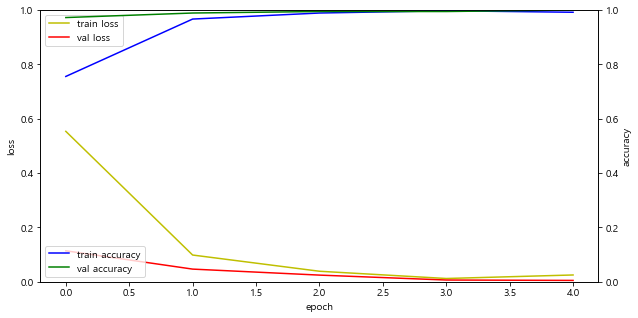

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.0]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1.0])

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차
acc_ax.set_ylabel('accuracy') # 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()

In [ ]:
print("-- Evaluate --")
scores = model.evaluate_generator(vali_generator, verbose=0)  
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --
accuracy: 100.00%


In [ ]:
print("-- Predict --")
output = model.predict_generator(vali_generator)
# 실수를 소수점 3자리까지 출력 설정
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

# 그룹의 index {'circle': 0, 'rectangle': 1, 'triangle': 2}, 알파벳 순
print(vali_generator.class_indices) # 분류에 할당된 index
print(type(output))
print(output.shape) # 검증 이미지가 15개, 3개의 분류임으로 출력은 15행 3열
print(output)

-- Predict --
{'circle': 0, 'rectangle': 1, 'triangle': 2}
<class 'numpy.ndarray'>
(180, 3)
[[0.000 0.000 1.000]
 [0.002 0.000 0.998]
 [1.000 0.000 0.000]
 [0.000 1.000 0.000]
 [1.000 0.000 0.000]
 [0.000 0.000 1.000]
 [0.982 0.017 0.000]
 [0.000 1.000 0.000]
 [0.000 1.000 0.000]
 [0.002 0.997 0.000]
 [0.001 0.999 0.000]
 [0.998 0.002 0.000]
 [1.000 0.000 0.000]
 [0.000 1.000 0.000]
 [0.788 0.212 0.000]
 [0.000 1.000 0.000]
 [0.000 1.000 0.000]
 [0.000 1.000 0.000]
 [1.000 0.000 0.000]
 [1.000 0.000 0.000]
 [0.000 1.000 0.000]
 [0.000 0.012 0.988]
 [0.000 1.000 0.000]
 [0.000 1.000 0.000]
 [1.000 0.000 0.000]
 [0.999 0.001 0.000]
 [0.000 0.000 1.000]
 [0.999 0.001 0.000]
 [0.999 0.001 0.000]
 [1.000 0.000 0.000]
 [1.000 0.000 0.000]
 [0.000 1.000 0.000]
 [0.000 1.000 0.000]
 [0.000 1.000 0.000]
 [0.999 0.001 0.000]
 [0.000 0.000 1.000]
 [0.000 0.000 1.000]
 [0.000 1.000 0.000]
 [0.000 1.000 0.000]
 [0.000 1.000 0.000]
 [0.000 1.000 0.000]
 [1.000 0.000 0.000]
 [0.000 1.000 0.000]
 [0.0

In [ ]:
def display(data):
    sw = np.argmax(data)
    print('sw:', sw)
    
    if sw == 0:
        sw = '원'
    elif sw == 1:
        sw = '사각형'
    elif sw == 2:
        sw = '삼각형'
        
    return sw     

In [ ]:
# 테스트용 데이터 생성기
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        './test1',
        target_size=(width, height),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: 원 /', display(yp))    # 2차원 텐서 전달
# 테스트 데이터가 여러건일 경우
# for one in yp: 
#    print('타겟: 사각형 /', display(one))     

Found 1 images belonging to 1 classes.
[[0.849 0.147 0.004]]
sw: 0
타겟: 원 / 원


In [ ]:
# 테스트용 데이터 생성기
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        './test2',
        target_size=(width, height),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: 사각형 /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[0.004 0.996 0.001]]
sw: 1
타겟: 사각형 / 사각형


In [ ]:
# 테스트용 데이터 생성기
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        './test3',
        target_size=(width, height),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: 삼각형 /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[0.130 0.010 0.860]]
sw: 2
타겟: 삼각형 / 삼각형


### 해상도 문제가 있는 경우
#### 훈련과 검증, 테스트 이미지의 해상도가 다른경우
#### 정확도가 급격히 떨어질 수 있음
#### 해상도가 다른것을 권장하지 않음.

In [ ]:
# 64 X 64
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        './test4',
        target_size=(width, height),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: 원 /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[0.537 0.315 0.148]]
sw: 0
타겟: 원 / 원


In [ ]:
# 128 X 128
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        './test5',
        target_size=(width, height),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: 사각형 /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[0.245 0.518 0.236]]
sw: 1
타겟: 사각형 / 사각형


In [ ]:
# 256 X 256, 학습한 이미지와 크기가 다른 이미지 예측시 정확도 떨어짐.
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        './test6',
        target_size=(width, height),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: 삼각형 /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[0.227 0.345 0.428]]
sw: 2
타겟: 삼각형 / 삼각형


In [ ]:
# 256 X 256, 학습한 이미지와 크기가 다른 이미지 예측시 정확도 떨어짐.
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        './test7',
        target_size=(width, height),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: 삼각형 /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[0.104 0.041 0.855]]
sw: 2
타겟: 삼각형 / 삼각형
